In [222]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score 
import seaborn as sns

In [223]:
warnings.filterwarnings("ignore")
%matplotlib inline

### Load dataset

In [224]:
def load_dataset() -> (pd.DataFrame, pd.DataFrame):
    # From https://archive.ics.uci.edu/dataset/109/wine
    wine = fetch_ucirepo(id=109) 
    
    X = wine.data.features 
    y = wine.data.targets 

    print(f"===== X: {X.head()}")

    return X, y

In [225]:
X, y = load_dataset() # data, labels

===== X:    Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  Total_phenols  \
0    14.23       1.71  2.43               15.6        127           2.80   
1    13.20       1.78  2.14               11.2        100           2.65   
2    13.16       2.36  2.67               18.6        101           2.80   
3    14.37       1.95  2.50               16.8        113           3.85   
4    13.24       2.59  2.87               21.0        118           2.80   

   Flavanoids  Nonflavanoid_phenols  Proanthocyanins  Color_intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   0D280_0D315_of_diluted_wines  Proline  
0               

### Whitening
References: 
* https://towardsdatascience.com/pca-whitening-vs-zca-whitening-a-numpy-2d-visual-518b32033edf

In [226]:
class Whitening:
    X: np.ndarray
    m: int 
    n: int
    C: np.ndarray
    D: np.ndarray
    P: np.ndarray
    D_m12: np.ndarray

    def __init__(self, X: pd.DataFrame):
        self.X = X.values # convert to numpy array
        # Only apply it to the first features so that we can plot it in 2D
        self.X = self.X[:, :2]
        self.m = self.X.shape[0] # height
        self.n = self.X.shape[1] # width

    def whiten(self) -> np.ndarray:
        # Center the data
        self.X = self.X - self.X.mean(axis=0)
        
        # Sort samples for plotting with increasing colors
        self.X = self.X[self.X[:, 0].argsort(), :] # self.X.iloc[:, 0] selects all rows and the values from the first column

        self.C = self.X.T @ self.X / self.m

        # Decompose the covariance matrix using eigen-decomposition
        eig_vals, eig_vecs = np.linalg.eig(self.C)
        self.D = np.diag(eig_vals) # eig_vals is a vector, but we want a matrix
        self.P = eig_vecs

        # Compute the square-root of the inverse of D
        self.D_m12 = np.diag(np.diag(self.D)**(-0.5)) # 'm12' for power(minus 1/2)

#### PCA-Whitening

In [227]:
class PCAWhitening(Whitening):
    X: np.ndarray
    m: int 
    n: int
    C: np.ndarray
    D: np.ndarray
    P: np.ndarray
    D_m12: np.ndarray

    def __init__(self, X: pd.DataFrame):
        super().__init__(X)

    def whiten(self) -> np.ndarray:
        print("===== PCAWhitening")
        super().whiten()

        W_PCA = self.D_m12 @ self.P.T
        return W_PCA

#### ZCA-Whitening

In [228]:
class ZCAWhitening(Whitening):
    X: np.ndarray
    m: int 
    n: int
    C: np.ndarray
    D: np.ndarray
    P: np.ndarray
    D_m12: np.ndarray

    def __init__(self, X: pd.DataFrame):
        super().__init__(X)

    def whiten(self) -> np.ndarray:
        print("===== ZCAWhitening")
        super().whiten()

        Z_PCA = self.P @ self.D_m12 @ self.P.T # == P @ W_PCA
        return Z_PCA
        

In [229]:
PCA_whitening = PCAWhitening(X)
W_PCA = PCA_whitening.whiten()
ZCA_whitening = ZCAWhitening(X)
W_ZCA = ZCA_whitening.whiten()

===== PCAWhitening
self.X: [[-1.97061798 -0.82634831]
 [-1.59061798 -1.59634831]
 [-1.55061798  0.06365169]
 [-1.54061798  1.40365169]
 [-1.44061798 -0.28634831]
 [-1.39061798 -0.98634831]
 [-1.38061798 -0.34634831]
 [-1.36061798 -0.27634831]
 [-1.35061798 -0.66634831]
 [-1.34061798 -0.45634831]
 [-1.24061798  0.34365169]
 [-1.21061798 -0.20634831]
 [-1.19061798 -0.21634831]
 [-1.18061798 -0.61634831]
 [-1.18061798 -0.86634831]
 [-1.16061798 -1.44634831]
 [-1.16061798  0.55365169]
 [-1.13061798  1.97365169]
 [-1.04061798 -1.24634831]
 [-1.00061798  1.09365169]
 [-1.00061798 -0.82634831]
 [-1.00061798 -1.41634831]
 [-0.96061798  1.96365169]
 [-0.93061798 -0.17634831]
 [-0.92061798 -1.20634831]
 [-0.92061798 -0.94634831]
 [-0.92061798 -1.00634831]
 [-0.92061798 -0.50634831]
 [-0.92061798 -0.25634831]
 [-0.84061798 -0.72634831]
 [-0.83061798 -0.88634831]
 [-0.80061798  0.69365169]
 [-0.79061798 -1.14634831]
 [-0.78061798 -1.04634831]
 [-0.75061798  1.54365169]
 [-0.75061798  2.38365169]
 

In [230]:
# To facilitate plotting, we create a function that take a transformation matrix A
# that compute the transformed data and plot it
def scatter_with_variance(A, ax, title, cmap, input_data=X.values):
    values = np.linspace(0, 1, input_data.shape[0])
    mapper = cm.ScalarMappable(cmap=cmap)
    mapper.set_array([])
    colors = mapper.to_rgba(values)

    "A : transformation matrix to apply on X"
    # Transform data
    x = (A @ input_data.T).T
    ax.scatter(*x.T, c=colors) # x needs to have 2 dimensions 
    #ax.scatter([*x.T], [x.T], c=colors)
    ax.set_title(title+ "\n" + f"C={np.array2string(x.T@x/len(x), precision=2, suppress_small=True, floatmode='fixed')}")
    # Add variances in x and y direction
    ax.set_xlabel(f"Var={np.var(x.T[0]):.3f}")
    ax.set_ylabel(f"Var={np.var(x.T[1]):.3f}")

[[-1.97061798 -0.82634831]
 [-1.59061798 -1.59634831]
 [-1.55061798  0.06365169]
 [-1.54061798  1.40365169]
 [-1.44061798 -0.28634831]
 [-1.39061798 -0.98634831]
 [-1.38061798 -0.34634831]
 [-1.36061798 -0.27634831]
 [-1.35061798 -0.66634831]
 [-1.34061798 -0.45634831]
 [-1.24061798  0.34365169]
 [-1.21061798 -0.20634831]
 [-1.19061798 -0.21634831]
 [-1.18061798 -0.61634831]
 [-1.18061798 -0.86634831]
 [-1.16061798 -1.44634831]
 [-1.16061798  0.55365169]
 [-1.13061798  1.97365169]
 [-1.04061798 -1.24634831]
 [-1.00061798  1.09365169]
 [-1.00061798 -0.82634831]
 [-1.00061798 -1.41634831]
 [-0.96061798  1.96365169]
 [-0.93061798 -0.17634831]
 [-0.92061798 -1.20634831]
 [-0.92061798 -0.94634831]
 [-0.92061798 -1.00634831]
 [-0.92061798 -0.50634831]
 [-0.92061798 -0.25634831]
 [-0.84061798 -0.72634831]
 [-0.83061798 -0.88634831]
 [-0.80061798  0.69365169]
 [-0.79061798 -1.14634831]
 [-0.78061798 -1.04634831]
 [-0.75061798  1.54365169]
 [-0.75061798  2.38365169]
 [-0.75061798 -0.60634831]
 

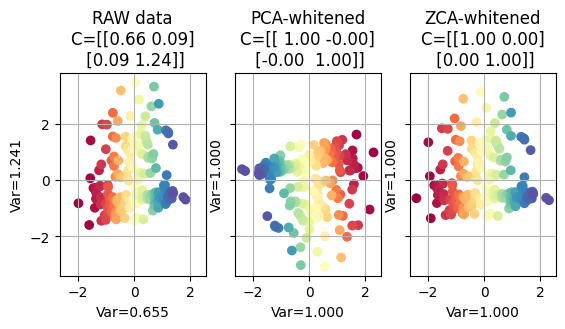

In [232]:
cmap = cm.get_cmap('Spectral')
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
scatter_with_variance(np.eye(PCA_whitening.X.shape[1]), axes[0], "RAW data", cmap, input_data=PCA_whitening.X) # identity matrix
scatter_with_variance(W_PCA, axes[1], "PCA-whitened", cmap, input_data=PCA_whitening.X)
scatter_with_variance(W_ZCA, axes[2], "ZCA-whitened", cmap, input_data=ZCA_whitening.X)

for ax in axes.flat:
    ax.set_aspect("equal")
    ax.grid()    

### Reproduce results in the references

===== PCAWhitening
self.X: [[-2.29700591 -1.53820154]
 [-2.19572553 -1.67408712]
 [-1.72393308 -2.25983501]
 [-1.65489403 -2.22211176]
 [-1.64528152 -1.09481294]
 [-1.5696913  -0.93700716]
 [-1.54414072 -1.4953452 ]
 [-1.45901874 -2.35395127]
 [-1.42827143 -0.54905678]
 [-1.38337229 -1.14454059]
 [-1.31756936 -0.99931943]
 [-1.16876392 -1.75524366]
 [-1.16279191 -0.18923689]
 [-1.16231943 -0.44343983]
 [-1.15583902 -1.43477566]
 [-1.12577203 -0.68244207]
 [-1.00528269 -0.26543908]
 [-1.00085223 -0.05427862]
 [-0.94979801 -1.0112259 ]
 [-0.94422067 -0.82306027]
 [-0.94030083 -0.91201151]
 [-0.93882256 -1.96861641]
 [-0.93756695 -1.45856909]
 [-0.87502296 -0.35346017]
 [-0.86798376 -0.44929425]
 [-0.74390969  0.84100942]
 [-0.73276079 -0.70643152]
 [-0.67027336 -1.55054508]
 [-0.64794176 -0.32728276]
 [-0.63117032 -0.99027968]
 [-0.61069715 -0.37524324]
 [-0.60738529 -0.05777122]
 [-0.58409818 -0.05790023]
 [-0.52485755  0.26062982]
 [-0.42720304 -1.23863001]
 [-0.35764264  0.2420109 ]
 

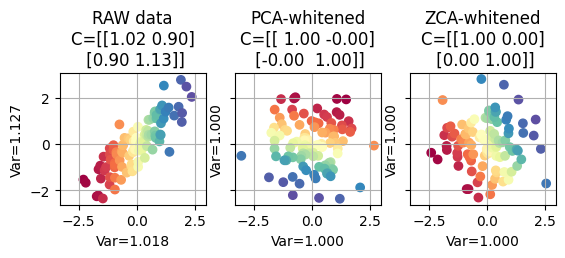

In [ ]:
m, n = 100, 2
X = np.random.multivariate_normal([0 for i in range(n)], np.array([[1, 0.8], [0.8, 1]]), size=m)
X = pd.DataFrame(X)
PCA_whitening = PCAWhitening(X)
W_PCA = PCA_whitening.whiten()
ZCA_whitening = ZCAWhitening(X)
W_ZCA = ZCA_whitening.whiten()

cmap = cm.get_cmap('Spectral')
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
scatter_with_variance(np.eye(X.shape[1]), axes[0], "RAW data", cmap, input_data=PCA_whitening.X) # identity matrix
scatter_with_variance(W_PCA, axes[1], "PCA-whitened", cmap, input_data=PCA_whitening.X)
scatter_with_variance(W_ZCA, axes[2], "ZCA-whitened", cmap, input_data=ZCA_whitening.X)

for ax in axes.flat:
    ax.set_aspect("equal")
    ax.grid()  
